# Markov chain modeling

In this tutorial, we implement a Markov chain model that allows for different orders. We demonstrate the model on human navigation data derived from Wikispeedia.

## Markov chain model

First, we implement the model

In [1]:
# further implementation can be found at https://github.com/psinger/PathTools

from __future__ import division

import itertools
from scipy.sparse import csr_matrix
from scipy.special import gammaln
from scipy.stats import chi2
from collections import defaultdict
from sklearn.preprocessing import normalize
import numpy as np

class MarkovChain():
    """
    Markov Chain Model
    """

    # dummy constant for our reset state
    RESET_STATE = "-1"

    def __init__(self, order=1, reset=True):
        """
        Constructor for class MarkovChain
        
        Args:
            order: Order of Markov Chain model
            reset: Boolean for using additional reset states
        """
        self.order = order
        self.reset = reset

    def fit(self,sequences):
        """
        Function for fitting the Markov Chain model given data
        
        Args:
            sequences: Data of sequences, list of lists
        """
        
        # first, we derive all basic states from given sequences
        states = set(itertools.chain.from_iterable(sequences))
        self.state_count = len(states)
        if self.reset:
            self.state_count += 1

        # dictionary of dictionaries for counting transitions between states
        transitions = defaultdict(lambda : defaultdict(float))

        # remember all start and target states that we observe
        # this is just necessary for memory saving reasons
        start_states = set()
        target_states = set()

        # iterate through sequences
        for seq in sequences:
            i = 0
            # Prepend and append correct amount of reset states if flag set
            if self.reset:
                seq = self.order*[self.RESET_STATE] + seq + [self.RESET_STATE]
            # iterate through elements of a sequence
            for j in xrange(self.order, len(seq)):
                # start state based on order
                elemA = tuple(seq[i:j])
                # target state based on order
                elemB = tuple(seq[j-self.order+1:j+1])
                i += 1

                # increase transition count
                transitions[elemA][elemB] += 1

                # remember start and target states
                start_states.add(elemA)
                target_states.add(elemB)

        # build vocabularies for mapping states to indices
        self.start_vocab = dict((v,k) for k,v in enumerate(start_states))
        self.target_vocab = dict((v,k) for k,v in enumerate(target_states))

        # transform transition dictionary of dictionaries to sparse csr_matrix
        i_indices = []
        j_indices = []
        values = []

        for s,ts in transitions.iteritems():
            for t,c in ts.iteritems():
                i_indices.append(self.start_vocab[s])
                j_indices.append(self.target_vocab[t])
                values.append(c)
        shape = (len(start_states), len(target_states))
        self.transitions = csr_matrix((values, (i_indices, j_indices)),
                                 shape=shape)

        #print "fit done"

    def loglikelihood(self):
        """
        Returns the loglikelihood given fitted model
        
        Returns:
            loglikelihood
        """
        
        # get mle by row-normalizing transition matrix
        self.mle = normalize(self.transitions,norm="l1",axis=1)
        # log mle
        mle_log = self.mle.copy()
        mle_log.data = np.log(mle_log.data)
        return self.transitions.multiply(mle_log).sum()

    @staticmethod
    def lrt(ln, pn, lt, pt):
        """
        Performs a likelihood ratio test given a null and alternative model
        
        Args:
            ln: loglikelihood of null model
            pn: nr. of parameters of null model
            lt: loglikelihood of alternative model
            pt: nr. of parameters of alternative model
        Returns:
            lr: log-likelihood ratio
            p_val: p value
        """
        
        # likelihood ratio
        lr = float(-2*(ln-lt))
        # degrees of freedom
        dof = float(pt - pn)
        # chi2 test
        p_val = chi2.sf(lr,dof)
        return lr, p_val

    def aic(self):
        """
        Determines the AIC given fitted model
        
        Returns:
            aic
        """
        ll = self.loglikelihood()
        # parameter count of model
        para = self.state_count**self.order*(self.state_count-1)
        return 2*para - 2*ll

    def bic(self):
        """
        Determines the BIC given fitted model
        
        Returns:
            bic
        """
        ll = self.loglikelihood()
        # parameter count of model
        para = self.state_count**self.order*(self.state_count-1)
        return para*np.log(self.transitions.sum()) - 2*ll

    def evidence(self, prior=1.):
        """
        Determines Bayesian evidence given fitted model
        
        Args:
            prior: Dirichlet prior parameter (symmetric)
        Returns:
            evidence
        """

        i_dim, j_dim = self.transitions.shape

        # elegantly calculate evidence
        evidence = 0
        evidence += i_dim * gammaln(self.state_count*prior)
        evidence -= gammaln(self.transitions.sum(axis=1)+self.state_count*prior).sum()
        evidence += gammaln(self.transitions.data+prior).sum()
        evidence -= len(self.transitions.data) * gammaln(prior)

        return evidence

## Slides example

For a first demonstration, we present the example from the slides consisting of blue and yellow states.

### Data

In [3]:
sequences = [["b","b","b","y","y","b","y","b","b","b","b"]]

### Fitting

We fit both a first and second order model and print the transition matrices.

In [4]:
print "First-order model"
mc1 = MarkovChain(reset=True, order=1)
mc1.fit(sequences)
print mc1.transitions.todense()

print "---------"
print "Second-order model"
mc2 = MarkovChain(reset=True, order=2)
mc2.fit(sequences)
print mc2.transitions.todense()

First-order model
[[ 1.  2.  0.]
 [ 2.  5.  1.]
 [ 0.  1.  0.]]
---------
Second-order model
[[ 0.  0.  0.  0.  1.  1.]
 [ 1.  3.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]]


### Model selection

Next, let us compare the two models.

In [5]:

print "First-order model"
print "Log-likelihood:", mc1.loglikelihood()
print "Evidence:", mc1.evidence()
print "AIC:", mc1.aic()
print "BIC:", mc1.bic()

print "---------"
print "Second-order model"

print "Log-likelihood:", mc2.loglikelihood()
print "Evidence:", mc2.evidence()
print "AIC:", mc2.aic()
print "BIC:", mc2.bic()

First-order model
Log-likelihood: -9.11159091503
Evidence: -13.4304361395
AIC: 30.2231818301
BIC: 33.1326217288
---------
Second-order model
Log-likelihood: -7.52394141841
Evidence: -14.3059048769
AIC: 51.0478828368
BIC: 59.776202533


The simpler, first-order model is to be preferred.

## Synthetic example

Now, let us generate synthetic data with given memory. We always start with the state "A" and add additional "B" states based on a given memory. Then, we repeat this process 1000 times. For example, for a simple Markovian first-order process, we would produce "ABABABAB...". For a third-order process we would produce "ABBBABBB...". Then, the model comparison criteria correctly determine corresponding Markov chain model as the most appropriate ones.

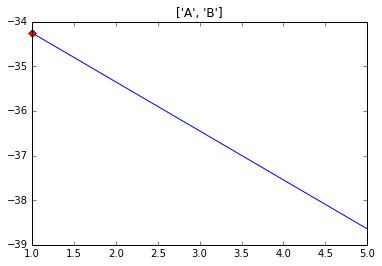

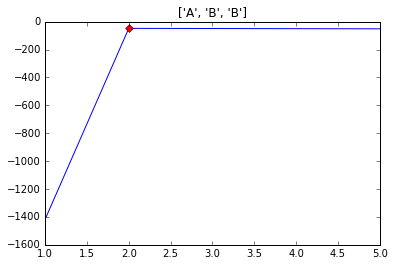

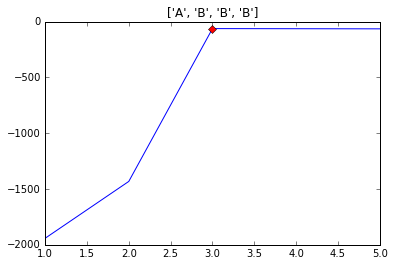

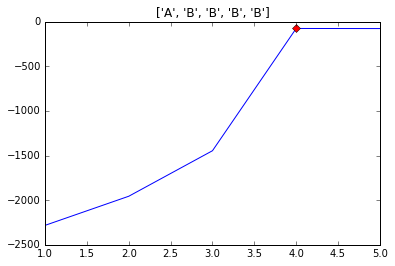

In [8]:
for o in xrange(1,5):
    sample = [(["A"]+["B"]*o)*1000]

    loglikelihoods = []
    aics = []
    bics = []
    evidences = []
    
    max_order = 5
    fig = plt.figure()

    for i in xrange(1,max_order+1):
        mc = MarkovChain(reset=True, order=i)
        mc.fit(sample)
        loglikelihoods.append(mc.loglikelihood())
        aics.append(mc.aic())
        bics.append(mc.bic())
        evidences.append(mc.evidence())
    
    # let us just plot the evidences here, the other criteria confirm these results
    ax = fig.add_subplot(111)
    ax.plot(xrange(1,max_order+1), evidences)
    max_index = evidences.index(max(evidences))
    ax.plot((xrange(1,max_order+1))[max_index], evidences[max_index], 'rD', clip_on = False)
    ax.set_title(sample[0][:o+1])



As expected, the modeling selection techniques also indicate those orders as the most plausible after which the data has been generated.

## Wikispeedia human Web navigation example

We now focus on an example of human Web navigation.

### Data

We load our data into a list of lists where each element corresponds to a sequence.

In [1]:
import csv
sequences = []

# from https://snap.stanford.edu/data/wikispeedia.html
for line in csv.reader((row for row in open("data/paths_finished.tsv") if not row.startswith('#')), delimiter='\t'):
    if len(line) == 0:
        continue
    # for simplicity, let us remove back clicks
    seq = line[3].split(";")
    # for simplicity, let us remove back clicks
    seq = [x for x in seq if x != "<"]
    sequences.append(seq)

In [2]:
print sequences[:10]

[['14th_century', '15th_century', '16th_century', 'Pacific_Ocean', 'Atlantic_Ocean', 'Accra', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Europe', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Niger', 'Nigeria', 'British_Empire', 'Slavery', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Renaissance', 'Ancient_Greece', 'Greece'], ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy'], ['14th_century', 'Europe', 'North_America', 'United_States', 'President_of_the_United_States', 'John_F._Kennedy'], ['14th_century', 'China', 'Gunpowder', 'Fire'], ['14th_century', 'Time', 'Isaac_Newton', 'Light', 'Color', 'Rainbow'], ['14th_century', 'Time', 'Light', 'Rainbow'], ['14th_century', '15th_century', 'Plato', 'Nature', 'Ultraviolet', 'Color', 'Rainbow']]


In [3]:
len(sequences)

51318

### Fitting

We now fit the Markov chain model to the data. We vary the order from 1 to 5. Additionally, we determine all model comparison techniques and store them for each order at hand.

In [5]:
loglikelihoods = []
aics = []
bics = []
evidences = []
lrts = []

max_order = 5

for i in xrange(1,max_order+1):
    mc = MarkovChain(reset=True, order=i)
    mc.fit(sequences)
    loglikelihoods.append(mc.loglikelihood())
    aics.append(mc.aic())
    bics.append(mc.bic())
    evidences.append(mc.evidence())

for i, ln in enumerate(loglikelihoods):
    for j, lt in enumerate(loglikelihoods[i+1:]):
        lrt = mc.lrt(ln, mc.state_count**(i+1)*(mc.state_count-1), lt, mc.state_count**(i+1+j+1)*(mc.state_count-1))
        lrts.append([str(i+1)+" vs. "+str(i+1+j+1),lrt[0],lrt[1]])

### Model Selection

Next, we select the most appropriate model.

#### Likelihood ratio test

Perform likelihood ratio test between all fits

In [6]:
print "orders | ", "likelihood ratio | ", "p-value"
for x in lrts:
    print " | ".join([str(k) for k in x])

orders |  likelihood ratio |  p-value
1 vs. 2 | 862481.65175 | 1.0
1 vs. 3 | 1405620.38073 | 1.0
1 vs. 4 | 1538326.871 | 1.0
1 vs. 5 | 1558210.23636 | 1.0
2 vs. 3 | 543138.728976 | 1.0
2 vs. 4 | 675845.219245 | 1.0
2 vs. 5 | 695728.584614 | 1.0
3 vs. 4 | 132706.490269 | 1.0
3 vs. 5 | 152589.855638 | 1.0
4 vs. 5 | 19883.3653686 | 1.0


#### AIC, BIC and Evidence

Now, we determine the AIC, BIC and Evidence for all fits. Additionally, we plot the simple log-likelihood of the fits.

/home/psinger/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


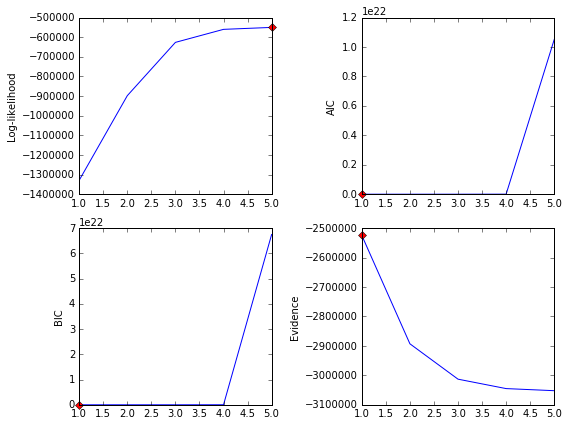

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(8,6))

x = xrange(1,max_order+1)

ax1.plot(x, loglikelihoods)
max_index = loglikelihoods.index(max(loglikelihoods))
ax1.plot(x[max_index], loglikelihoods[max_index], 'rD', clip_on = False)
ax1.set_ylabel("Log-likelihood")
ax2.plot(x, aics)
min_index = aics.index(min(aics))
ax2.plot(x[min_index], aics[min_index], 'rD', clip_on = False)
ax2.set_ylabel("AIC")
ax3.plot(x, bics)
min_index = bics.index(min(bics))
ax3.plot(x[min_index], bics[min_index], 'rD', clip_on = False)
ax3.set_ylabel("BIC")
ax4.plot(x, evidences)
max_index = evidences.index(max(evidences))
ax4.plot(x[max_index], evidences[max_index], 'rD', clip_on = False)
ax4.set_ylabel("Evidence")

plt.tight_layout()

#### Summary

All modeling comparison techniques indicate that a first-order Markov chain model sufficiently models given data. While higher order models always produce better fits due to nested models, their increasing number of necessary parameters does not fully justify their increasing complexity. However, with less states and/or more data, this might be different.